In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '29.04_06.05_scaling-up'

human36m_alg_AlgebraicTriangulationNet@03.05.2021-12:21:50 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/14807887.out)
training on 11872, evaluating on 703
found 47 epochs
training loss in [71.0, 4830.1]
training metrics in [24.5, 7748.6]
eval metrics in [52.9, 1260.7]
- plotted "training (min = 0.0, max = 3.3, last = 0.0)" metrics [0.0, 1.0] in epochs [0, 46]
- plotted "training metrics" metrics [24.5, 7748.6] in epochs [0, 46]
- plotted "eval metrics" metrics [52.9, 1260.7] in epochs [0, 46]
human36m_alg_AlgebraicTriangulationNet@05.05.2021-23:39:05 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/15057098.out)
training on 11872, evaluating on 703
found 14 epochs
training loss in [9983109.2, 32277200.4]
training metrics in [74.9, 229.1]
eval metrics in [86.2, 176.4]
- plotted "geo (min = 2.9, max = 3.1, last = 3.1)" metrics [0.0, 1.0] in epochs [0, 13]
- plotted "trans (min = 13.8, max = 21.3, last = 21.3)" metrics [0.0, 1.0] in epochs

Text(0.5, 0.98, 'cam2cam estimation (using predicted keypoints on 11872 / 703 train / validation images) optimizing just last 3 layers of BB, lr BB=1e-6')

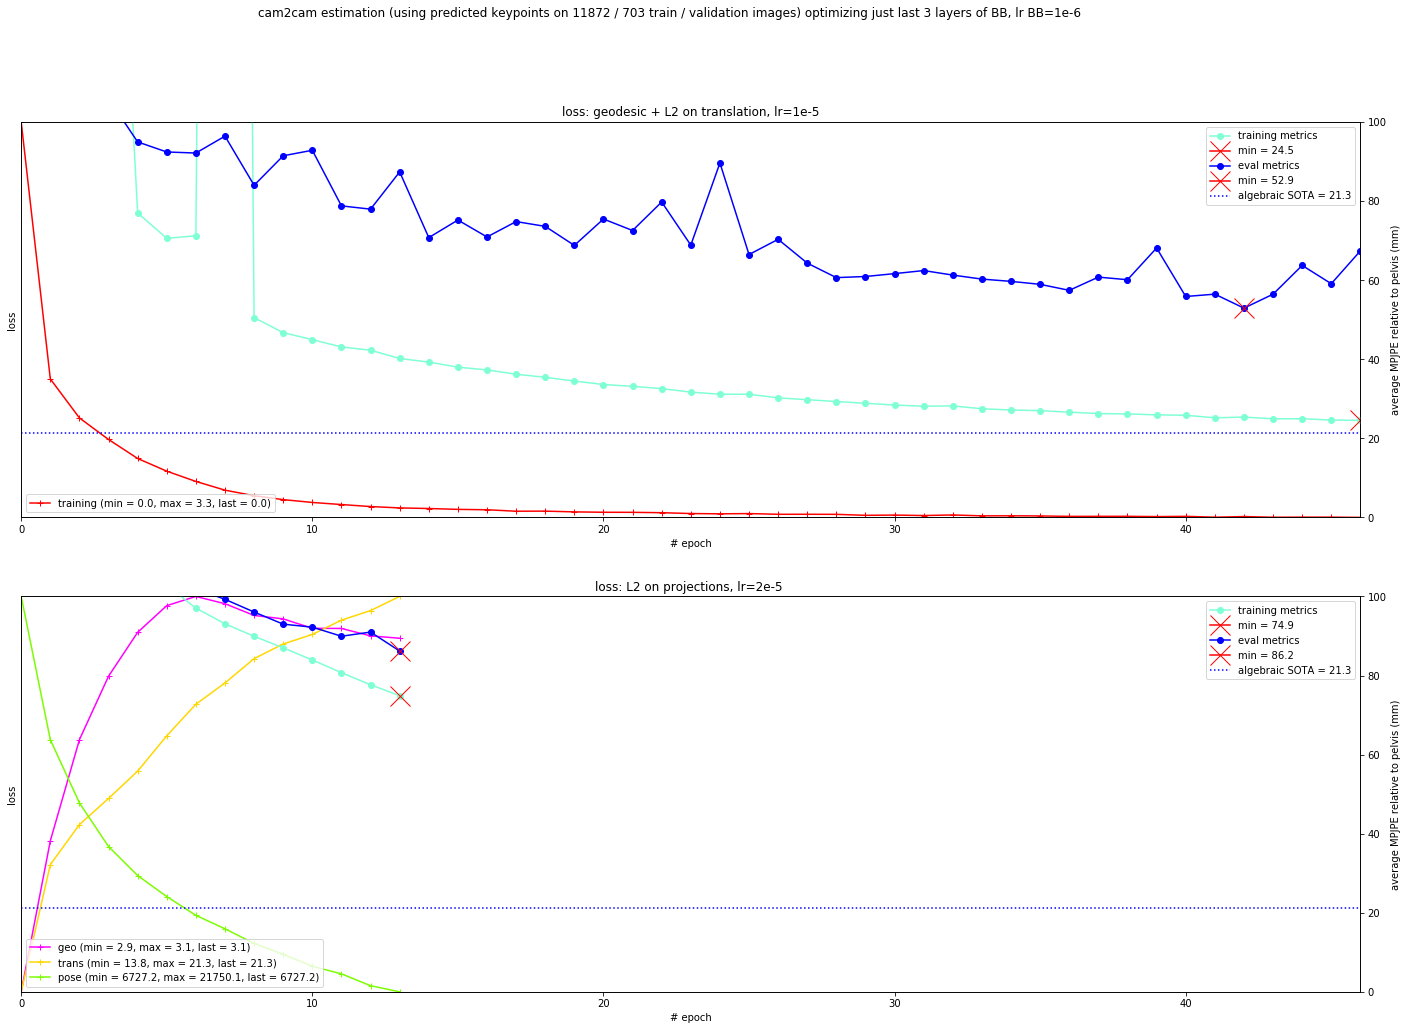

In [58]:
fig, axis = get_figa(2, 1, heigth=8, width=24)
metrics_ylim = [0, 100]
max_epochs = 47

job_id = '14807887'
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
ax = axis.ravel()[0]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 5e4],
    title='loss: geodesic + L2 on translation, lr=1e-5',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs - 1])


job_id = '15057098'
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
ax = axis.ravel()[1]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='loss: L2 on projections, lr=2e-5 ',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs - 1])

fig.suptitle('cam2cam estimation (using predicted keypoints on 11872 / 703 train / validation images) optimizing just last 3 layers of BB, lr BB=1e-6')
# cam2cam_geo_trans_VS_L2.png

In [60]:
import torch
from torch import nn

batch_size = 3
n_joints = 7
width = 5
height = 5

batch = torch.zeros(batch_size, 2, n_joints, width, height)
batch = torch.cat([
    batch[:, 0, ...],
    batch[:, 0, ...],
], dim=1)
batch.shape

torch.Size([3, 14, 5, 5])

In [63]:
from mvn.models.vgg import make_virgin_vgg

v = make_virgin_vgg(
    'smallest',
    batch_norm=False,
    in_channels=2 * n_joints,
    kernel_size=3,
    num_classes=8,
    init_weights=False
)
v(batch).shape

torch.Size([3, 8])